# HUA-treated embryos, nuclear size analysis

In [1]:
from cellpose import models
from cellpose.io import imread
from skimage import io as skio
from skimage import measure, transform, morphology, filters
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from parse import parse
import colorcet as cc
import os
import sys
from scipy import ndimage
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from aicsimageio import AICSImage
import aicsimageio
import xml.etree.ElementTree as ET
import seaborn as sns
from tqdm import tqdm
import tifffile as tif
import pickle
import time
plt.style.use("E:/Documents/Cohen Lab/bio_publications.mplstyle")

In [2]:
rootdir = Path("E:/Documents/Cohen Lab/Papers/Kalki_CellCycle/20240423_HUA_nuclear_size")
all_data = {}

In [3]:
def write_imagej_file(img, filepath, dx=1, dz=1):
    with open("E:/Documents/Cohen Lab/Code/imagej_metadata_template.pkl", "rb") as f:
        imagej_metadata = pickle.load(f)

    imagej_metadata['images'] = np.prod(img.shape[:3])
    imagej_metadata['spacing'] = dz
    imagej_metadata['min'] = np.min(img[0,:,1,:,:])
    imagej_metadata['max'] = np.max(img[0,:,1,:,:])
    imagej_metadata['Ranges'] = (np.min(img[:,:,0,:,:]), np.max(img[:,:,0,:,:]), np.min(img[:,:,1,:,:]), np.max(img[:,:,1,:,:]))
    page_labels = []
    for i in range(img.shape[1]):
        for j in range(img.shape[2]):
            page_labels.append(f"c:{j+1}/{img.shape[2]}, z:{i+1}/{img.shape[1]} - Series0")
    imagej_metadata['Labels'] = page_labels
    imagej_metadata['Info'] = f"BitsPerPixel = 16\n DimensionOrder = XYCZT\n IsInterleaved = false\n IsRGB = false\n LittleEndian = true\n PixelType = uint16\n Series 0 Name = null\n SizeC = {img.shape[2]}\n SizeT = {img.shape[0]}\n SizeX = {img.shape[4]}\n SizeY = {img.shape[3]}\n SizeZ = {img.shape[1]}\n \Location = {filepath}"
    tif.imwrite(filepath, img, imagej=True, metadata=imagej_metadata, resolution=[1/dx, 1/dx])



## Perform cellpose segmentation.
Use human-in-the-loop custom trained model "CP_20240424_nuclear_high_bg" to deal with unexpectedly high background from DRAQ7 staining.

In [26]:
conditions = ["Ctrl", "HUA"]

cell_sizes = [23, 23, 23]
flow_thresholds = [0.2, 0.2, 0.2]
target_dx = np.array([0.414, 0.414, 0.414])
model = models.CellposeModel(gpu=True, model_type='CP_20240424_nuclear_high_bg')


In [ ]:
for idx in range(2):
    condition = conditions[idx]
    combined_props = pd.DataFrame()
    subfolder = rootdir
    os.makedirs(rootdir/"analysis"/condition/"masks", exist_ok=True)
    czi_files = list(subfolder.glob("*.czi"))
    parse_format = "{condition}_{immunostain}_{timepoint}_{tissue}_E{embryo:d}-{num:2d}.czi"
    curr_condition_files = [czi_file for czi_file in czi_files if condition in czi_file.name]
    for czi_file in tqdm(curr_condition_files):

        file_info = parse(parse_format, czi_file.name)
        czi = AICSImage(czi_file)
        x = czi.metadata.find("Metadata")
        # Find the element "Scaling" recursively in the children of x
        scaling = x.find(".//Scaling")
        # Find the element "Distance" with attribute "Id" equal to "X"
        dx = float(scaling.find(".//Distance[@Id='X']").find("Value").text)*1e6
        dz = float(scaling.find(".//Distance[@Id='Z']").find("Value").text)*1e6
        print(f"dx: {dx}, dz: {dz}")
        print("Channels:", czi.channel_names)
        # Find element of czi.channel_names that contains "AF633"
        nuc_channel = [i for i, s in enumerate(czi.channel_names) if "AF633" in s][0]
        img = czi.get_image_data("ZYXC", C=[nuc_channel])
        img = ndimage.median_filter(img, footprint=np.ones((1,3,3,1)))
        downsample_factor = np.round(dx/target_dx[idx], decimals=2)
        print(f"Downsampling by {downsample_factor}x")
        print(img.shape)
        if downsample_factor != 1:
            img=transform.rescale(img, (1, downsample_factor, downsample_factor, 1), anti_aliasing=True, preserve_range=True, order=1)
        print(img.shape)

        # Run cellpose
        cell_size = cell_sizes[idx]
        flow_threshold = flow_thresholds[idx]
        masks, flows, styles = model.eval(img[:,:,:,0], diameter=cell_size, channels=[0,0], 
                                                    do_3D=True, anisotropy=dz/(target_dx[idx]), min_size=600, flow_threshold=flow_threshold)
        filepath = str(rootdir/"analysis"/condition/"masks"/f"{file_info['condition']}_{file_info['immunostain']}_{file_info['timepoint']}_{file_info['tissue']}_E{file_info['embryo']}_mask.tif")
        mask_overlay = np.zeros((1,masks.shape[0],2,masks.shape[1], masks.shape[2]), dtype=np.uint16)
        mask_overlay[0,:,0,:,:] = img[:,:,:,0]
        mask_overlay[0,:,1,:,:] = masks
        write_imagej_file(mask_overlay, filepath, dx=target_dx[idx], dz=dz)
        
        
        # Measure properties of the masks
        props = measure.regionprops_table(masks, properties=["label", "area", "centroid"])
        props = pd.DataFrame(props)
        props["immunostain"] = file_info["immunostain"]
        props["embryo"] = file_info["embryo"]
        props["condition"] = file_info["condition"]
        props["timepoint"] = file_info["timepoint"]
        props["tissue"] = file_info["tissue"]
        props["volume_um3"] = props["area"] * dz*(target_dx[idx])**2

        
        # Collect and save results
        props.to_csv(rootdir/"analysis"/condition/f"{file_info['condition']}_{file_info['immunostain']}_{file_info['timepoint']}_{file_info['tissue']}_E{file_info['embryo']}_props.csv", index=False)
        combined_props = pd.concat([combined_props, props], axis=0)
        combined_props.to_csv(rootdir/"analysis"/condition/f"combined_props_{condition}.csv", index=False)
    all_data[condition] = combined_props


### Clean up segmentation data

In [28]:
# group all timepoints
all_data = pd.concat([pd.read_csv(rootdir/"analysis"/condition/f"combined_props_{condition}.csv") for condition in conditions], axis=0)
all_data.to_csv(rootdir/"analysis"/"all_data_combined.csv", index=False)

In [56]:
all_timepoint_data = pd.read_csv(rootdir/"analysis"/"all_data_combined.csv")
all_timepoint_data["genotype"] = all_timepoint_data["condition"].map({"emi1": "hi2648", "Ctrl": "Ctrl", "HUA": "HUA"})
all_timepoint_data["tissue"] = all_timepoint_data["tissue"].map({"tailbud": "Tailbud", "gastrula": "Gastrula"})
all_timepoint_data.loc[:, "sample"] = all_timepoint_data.apply(lambda x: f"{x['genotype']}_{x['immunostain']}_{x['timepoint']}_{x['tissue']}_E{x['embryo']}", axis=1)
all_timepoint_data["hpf"] = all_timepoint_data["timepoint"].apply(lambda x: int(x[:-3]))

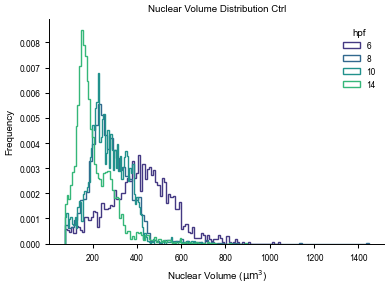

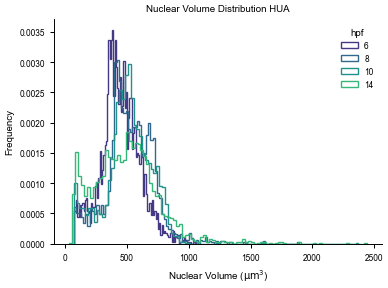

In [58]:
colormap = sns.color_palette("viridis", n_colors = 5)
for genotype, data in all_timepoint_data.groupby("genotype"):
    fig, ax = plt.subplots(figsize=(4,3))
    for idx, (name, group) in enumerate(data.groupby("hpf")):        
        ax.hist(group["volume_um3"], bins=100, label=name, alpha=1, density=True, color=colormap[idx], histtype="step")
    ax.set_xlabel(r"Nuclear Volume ($\mathrm{\mu m^3}$)")
    ax.set_ylabel("Frequency")
    ax.legend(title="hpf")
    ax.set_title(f"Nuclear Volume Distribution {genotype}")
    plt.tight_layout()
    plt.savefig(rootdir/"analysis"/f"nuclear_volume_distribution_{genotype}.svg")

In [59]:
nuc_size_cutoff = 80
df_filtered = pd.DataFrame(all_timepoint_data.loc[all_timepoint_data["volume_um3"] > nuc_size_cutoff,:])
df_filtered.to_csv(rootdir/"analysis"/"filtered_props.csv", index=False)

In [60]:
df_filtered = pd.read_csv(rootdir/"analysis"/"filtered_props.csv")

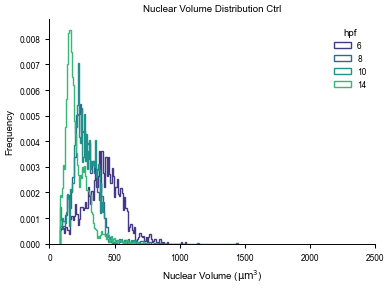

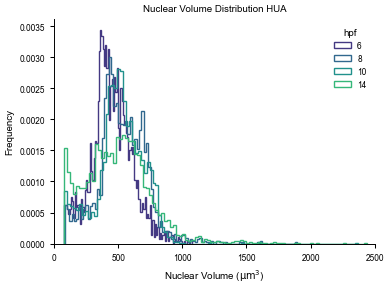

In [61]:
colormap = sns.color_palette("viridis", n_colors = 5)
for genotype, data in df_filtered.groupby("genotype"):
    fig, ax = plt.subplots(figsize=(4,3))
    for idx, (name, group) in enumerate(data.groupby("hpf")):        
        ax.hist(group["volume_um3"], bins=100, label=name, alpha=1, density=True, color=colormap[idx], histtype="step")
    ax.set_xlabel(r"Nuclear Volume ($\mathrm{\mu m^3}$)")
    ax.set_ylabel("Frequency")
    ax.legend(title="hpf")
    ax.set_title(f"Nuclear Volume Distribution {genotype}")
    ax.set_xlim(0, 2500)
    plt.tight_layout()
    plt.savefig(rootdir/"analysis"/f"nuclear_volume_distribution_filtered_{genotype}.svg")

In [62]:
median_nuclear_volume = df_filtered.groupby(["sample"]).agg({"volume_um3": "median",
"genotype": "first", "tissue": "first", "timepoint": "first", "hpf": "first"}).reset_index()


In [64]:
# Plot median nuclear volume per sample grouped by genotype and timepoint
median_nuclear_volume = df_filtered.groupby(["sample"]).agg({"volume_um3": "median", "genotype": "first", "tissue": "first", "timepoint": "first", "hpf": "first"}).reset_index()
median_nuclear_volume.to_csv(rootdir/"analysis"/"median_nuclear_volume.csv", index=False)

In [65]:
median_nuclear_volume = pd.read_csv(rootdir/"analysis"/"median_nuclear_volume.csv")
median_nuclear_volume["genotype_tissue"] = median_nuclear_volume["genotype"] + "_" + median_nuclear_volume["tissue"]

Text(0, 0.5, 'Median nuclear volume ($\\mathrm{\\mu m^3}$)')

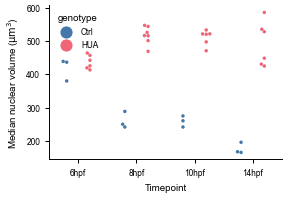

In [67]:
fig1, ax1 = plt.subplots(figsize=(3,2))
x_order = ["6hpf", "8hpf", "10hpf", "14hpf"]
sns.swarmplot(data=median_nuclear_volume, x="timepoint", y="volume_um3", hue="genotype", order=x_order, dodge=True, ax=ax1, size=2.5)
ax1.set_xlabel("Timepoint")
ax1.set_ylabel(r"Median nuclear volume ($\mathrm{\mu m^3}$)")